In [ ]:
] activate "./Environment/"

In [2]:
using NBInclude
@nbinclude("./Environment/Setup.ipynb");
using Plots; pyplot();

In [3]:
@nbinclude("./ConstructBuilder_Simulator-withAfunctionalresistance-v2.ipynb");

# Calculate cleavage/end joining rates

d = proportion of offspring which inherit the construct

e = probability of homing (cleavage and successful conversion to transgene)

p = proportion of non-homed chromosomes which are WT

u = 1-p = proportion of non-homed chromosomes which are mutant

c = probability of cleavage

j = probability of end joining given cleavage

In [4]:
d,e,c,j,u,p = symbols("d e c j u p");

#probability of homing (e) as a function of 
#the proportion of offspring which inherit the construct (d)
e = (2*d)-1
prob_not_homed = 1-e

#probability of a WT allele is
#probability of non-homing event (no cleavage or end-joining)
#multiplied by the probability of a non-cleaved allele being WT
prob_WT = prob_not_homed*(1-u)

#probability of a mutant allele is
#probability of non-homing event (no cleavage or end-joining)
#multiplied by the probability of a non-cleaved allele being mutant
prob_NHEJ_product = prob_not_homed*(u)

#probability of cleavage is
#probability of homing + the probability of a NHEJ
prob_cleavage = e + prob_NHEJ_product

#probability of NHEJ given cleavage is
#probability of NHEJ/ all cleavage events
prob_joining = prob_NHEJ_product/(prob_cleavage);

c = simplify(prob_cleavage)
j = simplify(prob_joining);

In [5]:
#our data is in the form of p, rather than u, so substitute in u = 1-p
c = subs(c,(u,1-p))
j = subs(j,(u,1-p));

In [6]:
cf_ = subs(c,(d,0.927),(p,0.734))
cm_ = subs(c,(d,0.913),(p,0.734))
jf_ = subs(j,(d,0.927),(p,0.734))
jm_ = subs(j,(d,0.913),(p,0.734))

println(cf_)
println(cm_)
println(jf_)
println(jm_)

0.892836000000000
0.872284000000000
0.0434973500172484
0.0530607004140853


# Simulations

In [7]:
function extract_freq(genotype_freq_store,allele)
    
    mask = [(occursin(allele,i[1])) | (occursin(allele,i[2])) for i in genotypes]
    output = genotype_freq_store[!,mask]
    carriers = sum.(eachrow(output))
    return(carriers)
end

extract_freq (generic function with 1 method)

In [8]:
#Set up model constants
A_construct = ["cas9","grna"]
B_construct = [] #Only a single construct modelled here

fitness_effect = "adult"

A_homing_dependency = "constitutive"
B_homing_dependency = "conditional" #Only a single construct modelled here so this doesnt matter
XS_dependency = "none" #No X-shredder

#The new costs are associated with the functional allele
Aallele_fitness = "o"

#initiate population
transgenic_genotype = "ABaB"
release_freq = 0.2
resistant_allele = "α"
resistant_freq = 0.0

#initiate both sexes at 20% of the population
params =  Initiate_baseline_parameters()
pre_release_pop = Initiate_prerelease_population_3lifestages(resistant_allele, resistant_freq, params)
pre_release_pop[:,"ABAB"] = [1.0,1.0,1.0,1.0,1.0,1.0]
pre_release_pop[:,"ABAB"] .= 1.0-release_freq
pre_release_pop[:,transgenic_genotype] .= release_freq
starting_population_post_release = transpose(Array(pre_release_pop));

## Data for fig 4

In [9]:
t=3;

In [10]:
#Sim DOCKING LINE
params =  Initiate_baseline_parameters()

params["siaf"] = 1.0 #homozygous KO cost in females = 1
params["hiaf"] = 0.0
params["sraf"] = 0.0
params["hraf"] = 0.0
params["siraf"] = 0.0

params["siam"] = 1.0 #homozygous KO cost in females = 1
params["hiam"] = 0.0
params["sram"] = 0.0
params["hram"] = 0.0
params["siram"] = 0.0

matrices = make_matrices(params,
                A_construct,
                B_construct,
                A_homing_dependency,
                B_homing_dependency,
                XS_dependency,
                Aallele_fitness);
output = Simulate_timeseries(
                params,
                matrices,
                XS_dependency,
                fitness_effect,
                t,
                starting_population_post_release)
data_dict = Simulation_processing_wrapper(output)
freq_transgenic_docking = extract_freq(data_dict["genotypefreq_zygote"],"a")

4-element Array{Float64,1}:
 0.2
 0.19
 0.1735537190082645
 0.15972222222222224

In [11]:
#Sim CRISPR
params =  Initiate_baseline_parameters()
params["siaf"] = 1.0 #homozygous KO cost in females = 1
params["hiaf"] = 0.0 
params["sraf"] = 0.0 
params["hraf"] = 0.0
params["siraf"] = 0.0 

params["siam"] = 1.0 #homozygous KO cost in males = 1
params["hiam"] = 0.0
params["sram"] = 0.0 
params["hram"] = 0.0
params["siram"] = 0.0 

#add in homing rates
params["caf"] = cf_ #cleavage in females
params["jaf"] = jf_ #end joining in females
params["cam"] = cm_ #cleavage in males
params["jam"] = jm_ #end joining in males


matrices = make_matrices(params,
                A_construct,
                B_construct,
                A_homing_dependency,
                B_homing_dependency,
                XS_dependency,
                Aallele_fitness);
output = Simulate_timeseries(
                params,
                matrices,
                XS_dependency,
                fitness_effect,
                t,
                starting_population_post_release)
data_dict = Simulation_processing_wrapper(output)
freq_transgenic_CRISPR = extract_freq(data_dict["genotypefreq_zygote"],"a")

4-element Array{Float64,1}:
 0.2
 0.3341459600000001
 0.48867130024401617
 0.6457586185303885

In [12]:
#Sim CRISPR with observed costs
params =  Initiate_baseline_parameters()

params["siaf"] = 1.0 #homozygous KO cost in females = 1
params["hiaf"] = 0.0 
params["sraf"] = 0.0
params["hraf"] = 0.0
params["siraf"] = 0.0

params["siam"] = 1.0 #homozygous KO cost in males = 1
params["hiam"] = 0.0
params["sram"] = 0.0
params["hram"] = 0.0
params["siram"] = 0.0

#add in homing
params["caf"] = cf_ #cleavage in females
params["jaf"] = jf_ #end joining in females
params["cam"] = cm_ #cleavage in males
params["jam"] = jm_ #end joining in males

#lower hatching rate of offspring from CRISPR/WT females crossed to WT males
params["sFiaf"]=0.216
params["hFiaf"]=1.0
params["sFraf"]=0.0
params["hFraf"]=1.0
params["sFiraf"]=0.0

# % of larvae which emerge to adulthood is lower from CRISPR/WT x WT crosses
# Assuming this is due to somatic expression:
params["sSaf"]=0.462 # females
params["sSam"]=0.378 # males

matrices = make_matrices(params,
                A_construct,
                B_construct,
                A_homing_dependency,
                B_homing_dependency,
                XS_dependency,
                Aallele_fitness);
output = Simulate_timeseries(
                params,
                matrices,
                XS_dependency,
                fitness_effect,
                t,
                starting_population_post_release)
data_dict = Simulation_processing_wrapper(output)
freq_transgenic_CRISPR_cost = extract_freq(data_dict["genotypefreq_zygote"],"a")

4-element Array{Float64,1}:
 0.2
 0.3067764555183947
 0.2917500081845626
 0.27694179041768574

In [13]:
#Sim CRISPR with added costs
params =  Initiate_baseline_parameters()

params["siaf"] = 1.0 #homozygous KO cost in females = 1
params["hiaf"] = 0.0 
params["sraf"] = 0.0
params["hraf"] = 0.0
params["siraf"] = 0.0

params["siam"] = 1.0 #homozygous KO cost in males = 1
params["hiam"] = 0.0
params["sram"] = 0.0
params["hram"] = 0.0
params["siram"] = 0.0

#add in homing
params["caf"] = cf_ #cleavage in females
params["jaf"] = jf_ #end joining in females
params["cam"] = cm_ #cleavage in males
params["jam"] = jm_ #end joining in males

#lower hatching rate of offspring from CRISPR/WT females crossed to WT males
params["sFiaf"]=0.216
params["hFiaf"]=1.0
params["sFraf"]=0.0
params["hFraf"]=1.0
params["sFiraf"]=0.0

# % of larvae which emerge to adulthood is lower from CRISPR/WT x WT crosses + additional costs 
# Assuming this is due to somatic expression:
params["sSaf"]=0.9 # females
params["sSam"]=0.9 # males

matrices = make_matrices(params,
                A_construct,
                B_construct,
                A_homing_dependency,
                B_homing_dependency,
                XS_dependency,
                Aallele_fitness);
output = Simulate_timeseries(
                params,
                matrices,
                XS_dependency,
                fitness_effect,
                t,
                starting_population_post_release)
data_dict = Simulation_processing_wrapper(output)
freq_transgenic_CRISPR_cost_09 = extract_freq(data_dict["genotypefreq_zygote"],"a")


4-element Array{Float64,1}:
 0.2
 0.3067764555183947
 0.062412427894549774
 0.010593441659927127

## Data for fig S1

In [14]:
function experimental_costs_sim(pa_freq)
    
    params =  Initiate_baseline_parameters()
    
    params["siaf"] = 1.0
    params["hiaf"] = 0.0
    params["sraf"] = 0.0
    params["hraf"] = 0.0
    params["siraf"] = 0.0

    params["siam"] = 1.0
    params["hiam"] = 0.0
    params["sram"] = 0.0
    params["hram"] = 0.0
    params["siram"] = 0.0
    
    #lower hatching rate of offspring from CRISPR/WT females crossed to WT males
    params["sFiaf"]=0.216
    params["hFiaf"]=1.0
    params["sFraf"]=0.0
    params["hFraf"]=1.0
    params["sFiraf"]=0.0

    # % of larvae which emerge to adulthood is lower from CRISPR/WT x WT crosses
    # Assuming this is due to somatic expression:
    params["sSaf"]=0.462 # females
    params["sSam"]=0.378 # males

    #homing
    params["caf"] = cf_ #cleavage in females
    params["jaf"] = jf_ #end joining in females
    params["cam"] = cm_ #cleavage in males
    params["jam"] = jm_ #end joining in males

    #production of functional resistant alleles
    params["pa"] = pa_freq
    
    #Substitutute params into matrices
    matrices = make_matrices(params,
                    A_construct,
                    B_construct,
                    A_homing_dependency,
                    B_homing_dependency,
                    XS_dependency,
                    Aallele_fitness);

    output = Simulate_timeseries(
                    params,
                    matrices,
                    XS_dependency,
                    fitness_effect,
                    t,
                    starting_population_post_release)

    data_dict = Simulation_processing_wrapper(output)
    
    return(data_dict["genotypefreq_zygote"],data_dict["allelefreq_zygote"])
end


experimental_costs_sim (generic function with 1 method)

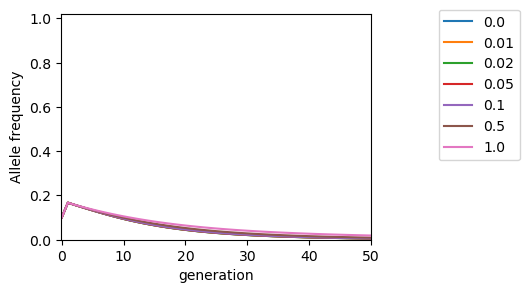

In [15]:
#Plot
f1 = PyPlot.figure(figsize=(4,3),frameon=false)

t=50
out = Dict()
pa_freq_vec = [0.0,0.01,0.02,0.05,0.1,0.5,1]

for pa_freq in pa_freq_vec
    genotype_freqz_store,allele_freqz = experimental_costs_sim(pa_freq);
    PyPlot.plot(0:t,allele_freqz[:,:a],label = pa_freq)
    out[string(pa_freq)] = extract_freq(genotype_freqz_store,"a")
end

PyPlot.xlim([-0.05,t+0.05])
PyPlot.ylim([0,1.02])
PyPlot.xlabel("generation",size=10)
PyPlot.ylabel("Allele frequency",size=10)

PyPlot.tight_layout()
lgd = PyPlot.legend(bbox_to_anchor=(1.5, 1.05))

PyPlot.show()

In [16]:
out_df = DataFrame(out)

,0.0,0.01,0.02,0.05,0.1,0.5,1.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2,0.306776,0.306776,0.306776,0.306776,0.306776,0.306776,0.306776
3,0.29175,0.291759,0.291767,0.291794,0.291837,0.292187,0.292626
4,0.276942,0.276966,0.27699,0.277063,0.277185,0.278161,0.279389
5,0.262093,0.262138,0.262183,0.262318,0.262543,0.264358,0.266657
6,0.247351,0.24742,0.24749,0.247697,0.248044,0.250846,0.254422
7,0.23285,0.232945,0.23304,0.233326,0.233803,0.23768,0.242675
8,0.2187,0.218822,0.218943,0.219309,0.21992,0.22491,0.231408
9,0.204994,0.205142,0.205289,0.205733,0.206476,0.212576,0.220613
